# NLP, N-grams and FastText

As you have seen in the lectures, NLP has a wide range of techniques and applications of such techniques. We will give you an introduction to some of these techniques, and today you will get hands-on experience with them. In today's exercise, we will look at the following topics:

1. How do we represent text in a vectorized way that encodes context? (One answer here is N-grams, and those we will look at).
2. How do we create and sample from an N-gram language model - and how does the size of the grams affect the generated text?
3. How do we use a pre-existing language model (FastText), to classify text messages as spam?

The data we will be using later today is a dataset consisting of "spam or ham" text messages. The dataset consists of a number of text messages, some of which are spam and some of which are so-called "ham". We will use FastText to classify mails as spam or ham. For now, we will be looking at some different texts, to see how we can use N-grams to generate text, and how we can create N-gram language models from a text corpus.

## Exercise 1: Text-loading


The texts we will be experimenting with N-grams on are the two famous books Pride & Prejudice by Jane Austen and The Origin of Species by Charles Darwin. The two books have been obtained in a raw text format from https://www.gutenberg.org/, i.e. Project Gutenberg which concerns itself with the collection of Open Access e-books.

A big part of working with text documents is unfortunately having to preprocess the documents. Preprocessing of these, can have a large impact on the eventual performance of language models, such as N-gram models. We have included the text-preprocessing steps in the cell below. In the output cell you will notice that the first chapter of pride and prejudice is printed out. It is then preprocessed using the `preprocess_text` function and printed out again.

**1. Implement the pre_processing function according to the following description:**
1. Remove empty characters using `.strip()`
2. All text should be lowercase 
    - *Python strings have an in-built method for that*
3. Remove all special characters by using the regex pattern `r"[^a-zA-Z0-9.?! \n]+"` and the sub function from Python's re module
4. Split the text by lines *"\n" is the character used for newlines*
5. Remove chapter headlines
6. Recreate the full document again using `"\n".join(text)`
7. Replace `"\n"` with `" "` and double-spacing with single spacing

In [1]:
import re
import os
import torch
import fasttext

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def preprocess_text(text):
    text = text.strip()
    text = text.lower() #Lowercase everything in text file.
    text = re.sub(r"[^a-zA-Z0-9.?! \n]+", "", text) #Remove unwanted special characters.
    text = text.split("\n") #Split text by lines.
    text = [line.strip() for line in text if line.find("chapter") == -1] #Remove chapter headlines.
    text = "\n".join(text) #Recreate full document again
    text = text.replace("\n", " ").replace("  ", " ") #Remove end lines and remove double spacing.
    return text

**2. The preprocessing is not perfect. Do you notice any issues in the text? Show examples of words that will may be problematic:**

*HINT: What happens to *good-humoured*? What happens to *three-and-twenty*? What happens to *Mr.* and *Mrs.*, and how will this later be handled when we split the sentences?*

If two words are separated by a character that we remove they will become a single word. And creating sentences through the use of full-stops means "Mr. Harvey" will become two sentences "Mr" and "Harvey".

In [3]:
print(preprocess_text("good-humoured"))
print(preprocess_text("Mr."))
print(preprocess_text("I am, but"))

goodhumoured
mr.
i am but


**3. Apply the preprocessing to Pride and Prejudice and the Origin of Species**

In [4]:
with open("data/pride_and_prejudice.txt", "r", encoding="utf-8") as file:
    pride_n_pred = file.read()
    pride_n_pred_preproc = preprocess_text(pride_n_pred)

In [5]:
with open("data/pride_and_prejudice.txt", "r", encoding="utf-8") as file:
    orig_of_spec = file.read()
    orig_of_spec_preproc = preprocess_text(orig_of_spec)

## Exercise 2: Creating N-grams

Now that we have the texts in the preprocessed document format we want, we will move forward with the creation of our N-grams. Recall we want to use the N-grams for probabilistic word modelling tasks, for example, next word predictions given some sequence of words which we can express the following way:

$$
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1})
$$
The problem is that estimating such probabilities for very long sequences is computationally and memory-wise VERY expensive. So as a solution we sometimes use N-grams. In N-grams, the assumption is that we can model these conditional dependencies with shorter sequences of words, i.e.:

$$
\begin{split}
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n) \quad \text{(Unigram)}\\
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n| w_{n-1}) \quad \text{(Bigram)}\\
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n|w_{n-2}, w_{n-1}) \quad \text{(Trigram)}\\
\end{split}
$$

Which we then compute as:

$$
P(w_n|w_{n-2}, w_{n-1}) = \frac{\text{Count}(w_{n-2}, w_{n-1}, w_n)}{\text{Count}(w_{n-2}, w_{n-1})}
$$
The language model that we create is based on some text corpus from which we obtain the count measures. In this exercise we will try making such N-gram models on the two books Origin of Species and Pride and Prejudice!

In the cell below we have written the functions required for preprocessing a corpus even further such that it is ready for creating an N-gram model on. In order to guarantee that we can just start text generation or give conditional probabilites for how likely a start or end word is in given sentence we pad our sentence with start and end tokens denoted as `<s>` and `</s>` according to the size of N-grams we are working with.

**1. Why do N-grams encode context in comparison to methods such as count vectorizers which just count words?**

The order of each word is taken into consideration and encoded in the representation.

**2. Implement the function `tokenize_and_pad` that takes a corpus and a parameter `N` specifying the amount of padding to apply and returns a list of lists where the inner lists are sentences split into words**
1. Split the corpus into sentences *Using a full stop as the delimiter*
2. Calculate the length of the padding needed
    - Think about how many words are needed to create the first N-gram? *Hint: The first actual word is included*
3. Create the padding for the front and end using for example `" ".join(list_of_start_chars)`
    - In Python you can create a list of length pad_len using `[el] * pad_len`
4. Pad each corpus sentence ensuring that there is a space between the padding and sentence
    - Use the .strip() method on each sentence to remove empty characters
Split the padded sentences into words and return a list of lists containing the split sentences

In [6]:
def tokenize_and_pad(corpus, N):
    corpus_sentences = corpus.split(".")
    pad_len = N - 1
    pad_front = " ".join(["<s>"]*pad_len)
    pad_end = " ".join(["</s>"]*pad_len)
    padded_corpus_sentences = [pad_front + " " + sentence.strip() + " " + pad_end for sentence in corpus_sentences]
    tokenized_corpus_sentences = [sentence.split(" ") for sentence in padded_corpus_sentences]
    return tokenized_corpus_sentences

In [7]:
N = 3
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
print(orig_of_spec_tokenize[0])

['<s>', '<s>', 'it', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '</s>', '</s>']


**3. Implement the function `create_n_grams` which takes the output from the above function and splits it into n_grams**
1. Create and empty list for the n_grams
2. Loop across all the tokenized sentences
3. Now loop across the range of applicable starting indexes for the given sentence
    - If N = 2, what's the length of the sentences list and how many N_grams can we create? Generalise this.
4. Create the current n_gram by using `" ".join`
5. Return the n_grams list


In [8]:
def create_n_grams(tokenized_sentences, N):
    n_grams = []
    for sentence in tokenized_sentences:
        for i in range(len(sentence) - N + 1):
            # Create each n-gram by joining N consecutive words
            n_gram = " ".join(sentence[i:i + N])
            n_grams.append(n_gram)
    return n_grams

In [9]:
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
print(orig_of_spec_n_grams[:20])

['<s> <s> it', '<s> it is', 'it is a', 'is a truth', 'a truth universally', 'truth universally acknowledged', 'universally acknowledged that', 'acknowledged that a', 'that a single', 'a single man', 'single man in', 'man in possession', 'in possession of', 'possession of a', 'of a good', 'a good fortune', 'good fortune must', 'fortune must be', 'must be in', 'be in want']


**4. Implement the function `n_grams_to_prob_map` which takes a list of n_grams as returned by the function above and create a dictionary which maps the probabilities of words occurring after a given context.**
1. If you are unfamiliar with the defaultdict class in Python, read this article before you start this task https://www.geeksforgeeks.org/defaultdict-in-python/
2. If you are unfamiliar with the lambda keyword in Python, read this article before you start this task https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/?ref=header_outind
3. Create a default dict, name it `contexts`, with a default value that is a default dict whose default value is 0
    - In essence: defaultdict(defaultdict(0))
    - This will be used to count how often each target word occurs after a certain context
4. Loop through every n-gram and split it
5. Create the context by using `" ".join` on all but the last token in the n-gram. The last token is the target
6. Increment (means adding 1 to a value) the counter for the target value for the given context
7. Create a new dictionary `cond_prob`
8. Loop across the keys of `contexts`
9. Create a list of each target in the current context by wrapping the .keys() call in a list()
10. Count the number of occurrences of each target in the current context and put them in a numpy array
11. Calculate the probabilities of each target by normalising the occurrence count 
    - Ensure it sums to 1
12.  Assign a tuple of the targets and their probabilities to the entry in the `cond_prob` function
    - The order of the tuple is important for later, so (context_targets, targets_probs)


In [10]:
def nested_default_dict():
    return defaultdict(lambda: 0)

def n_grams_to_prob_map(n_grams):
    contexts = defaultdict(nested_default_dict)
    for n_gram in n_grams:
        n_gram_split = n_gram.split(" ")
        context = " ".join(n_gram_split[:N-1])
        target = n_gram_split[N-1]
        contexts[context][target] += 1

    cond_prob = {}
    for context in contexts.keys():
        context_targets = list(contexts[context].keys())
        targets_count = np.array([contexts[context][target] for target in context_targets])
        context_sum = np.sum(targets_count)
        targets_probs = targets_count / context_sum
        cond_prob[context] = (context_targets, targets_probs,)
    return cond_prob

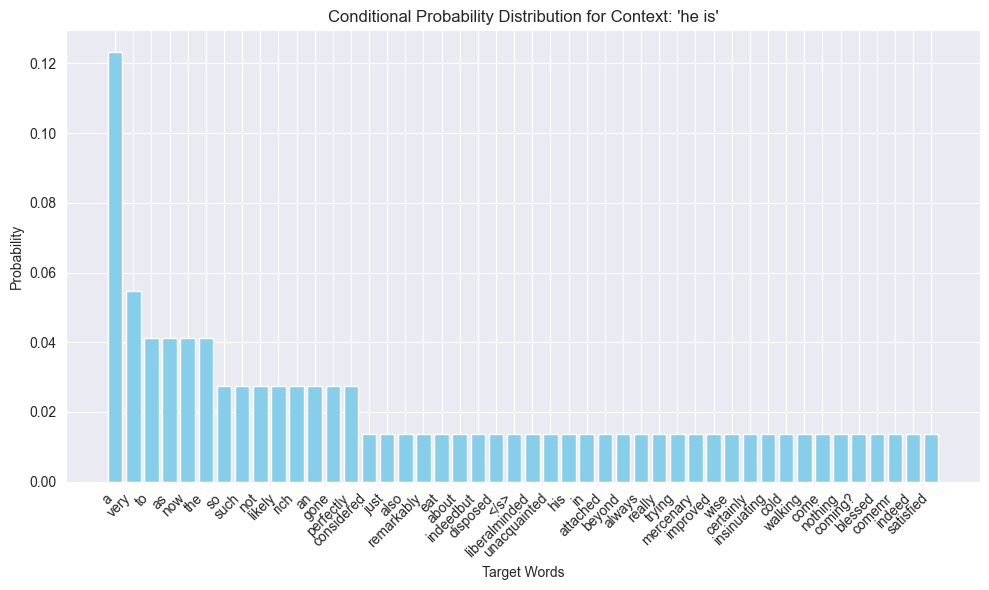

In [11]:
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)
context_test = " ".join(orig_of_spec_n_grams[60].split(" ")[:-1])   # "he is" has a good number of targets
targets, probs = orig_of_spec_cond_prob[context_test]

sorted_targets, sorted_probs = zip(*sorted(zip(targets, probs), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_targets, sorted_probs, color='skyblue')
plt.xlabel("Target Words")
plt.ylabel("Probability")
plt.title(f"Conditional Probability Distribution for Context: '{context_test}'")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout for readability
plt.show()

**5. Vary the N-gram size N and inspect the first 20 N-grams.**
 - How do they change and why? 
 - Do you think there could be issues with this?

One potential issue is that as N increases the number of each N-gram decrease, each one becomes unique due to its length.

In [146]:
N=4
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)
print(orig_of_spec_n_grams[:20])

['<s> <s> <s> it', '<s> <s> it is', '<s> it is a', 'it is a truth', 'is a truth universally', 'a truth universally acknowledged', 'truth universally acknowledged that', 'universally acknowledged that a', 'acknowledged that a single', 'that a single man', 'a single man in', 'single man in possession', 'man in possession of', 'in possession of a', 'possession of a good', 'of a good fortune', 'a good fortune must', 'good fortune must be', 'fortune must be in', 'must be in want']


## Exercise 3: Generating Text

In the previous exercise we saw how to tokenize a corpus such that it is ready to be split into n-grams. We then saw how to make n-grams and create a conditional probability based on these.

The question now is, how can we generate a text using this conditional probability. A way of doing this is to sample from a conditional probability distribution based on our obtained N-grams. In essence, we can give a seed to our conditional probability (also called a context), and then we need to generate a word from our conditional probability by sampling from it.

In the code below we will define a function that allows us to generate a sentence based on a provided conditional distribution. In the cell we create such a conditional distribution and generate 5 sentences using the same text seed. 

**1. Implement the `generate_text` function.**
1. Create a variable which will be the output string and assign the text_seed to it
2. Split the text_seed into words and check its length, it should be N-1
    - If the text seed is too short append the start character to it
    - If the text seed is too long change it to the last N-1 words
3. Create a variable that holds the current context (text_seed right now)
4. Loop across the number of words we wish to generate
   - If the current context is not in the `cond_prob` dictionary, return the generated sentence
   - If it is, sample a target word from the context according to its probability distribution and update the context for the next iteration


In [13]:
def generate_text(cond_prob, text_seed, N, num_words=25):
    generated_sentence = text_seed
    text_seed_words = text_seed.split(" ")
    if len(text_seed_words) < N-1:
        pad_len = N-1-len(text_seed_words)
        pad_list = ["<s>"]*pad_len
        text_seed = " ".join(pad_list+text_seed_words)
    elif len(text_seed_words) > N-1:
        text_seed = " ".join(text_seed_words[-N+1:]) #NOTE: Take ending words, not start sentences
    
    context = text_seed
    for i in range(num_words):
        if context not in cond_prob.keys():
            return generated_sentence
        else:
            generated_sentence += " " + np.random.choice(cond_prob[context][0], 1, p=cond_prob[context][1])[0]
            context = " ".join(generated_sentence.split(" ")[-N+1:])
    return generated_sentence

In [14]:
N=2
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)

In [15]:
text_seed = "he is a"
for i in tqdm(range(5)):
    print(generate_text(cond_prob=orig_of_spec_cond_prob, text_seed=text_seed, N=N) + "\n")

  0%|          | 0/5 [00:00<?, ?it/s]

he is a quadrille table and after the carriage turned back a man </s>

he is a quarter of this moment was to her of ten minutes after walking several years ago would now passed the reason to think it </s>

he is a hurry replied darcy contemptuously yes there was very happy for her letter to me hope to my excellent judgement alone quite happy effect </s>

he is a nice comfortable that she would not hope consider how his misfortunes replied sir to see the sideboard to the comforts and of talents or covering

he is a suitableness which fronted the necessity of the very agreeable his behalf is fortunate as possible of whom he had been strange it was the summer!



**2. Answer the following questions about the text generation you have just implemented:**
- Why is it that even though we use the same text seed, the generated sentences changes?

Because we are sampling from the distribution and not simply using the most probable word.

- What happens as you increase the N-gram size as shown in the cell below? Does this makes sense - and if so, why?

There are fewer and fewer examples of each context in the text which leads to less text being generated.

- Is it more optimal to have smaller or larger N-gram size? Try to experiment with generated sentences as N goes from 2->7.

The higher the n-gram size the fewer examples of each n-gram there is.

- What would it mean to set the N-gram size to one? What would you expect the generated text to look like?

There is not target for any context so no text is generated.

In [144]:
for N in tqdm(range(1, 8)):
    orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
    orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
    orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)
    print(f"{N}: {len(orig_of_spec_cond_prob.keys())}")

  0%|          | 0/7 [00:00<?, ?it/s]

1: 1
2: 7233
3: 54172
4: 101601
5: 120372
6: 128552
7: 134849


**3. We will now look at how the generated sentences changes depending on the corpus used to create our n-grams on.**

- Create N-grams and a conditional probability using the Pride and Prejudice corpus.
- Try to generate some sentences using both conditional probabilites but using the same text seed (use ngram size 3 for example and use the provided text seed for both n-gram models. What do you observe?

In [145]:
#Write your code here for creating a sentence generator using Pride and Prejudice as your corpus
#and comparing the two language models.
N=3
pride_n_pred_tokenize = tokenize_and_pad(pride_n_pred_preproc, N=N)
pride_n_pred_n_grams = create_n_grams(pride_n_pred_tokenize, N=N)
pride_n_pred_cond_prob = n_grams_to_prob_map(pride_n_pred_n_grams)

text_seed = "it is said that"

for i in range(5):
    print(generate_text(cond_prob=pride_n_pred_cond_prob, text_seed=text_seed, N=N)+ "\n")

it is said that i have by no means of exercising it and into it herself with an apprehensive and anxious attention while she remains with us for we

it is said that he was so completely awed by the sight of mr </s> </s>

it is said that he was comparatively diffident since the death of your admirer </s> </s>

it is said that she wished to think ill of her own more extensive information he was now employment for the felicity of her family </s> </s>

it is said that the two cousins found a temptation as one of her dark eyes </s> </s>



# FastText for Ham or Spam

In the following exercises we will be looking at classifying text messages as "Ham" or "Spam" by using Fasttext models. At first we will format our data to comply with the Fasttext library, then implement our own Pytorch model to run on the data and finally use the much faster Fasttext library to achieve the results. Remember that the coding is optional for this course and is mainly there for those who wish to get comfortable with Pytorch data loading (A highly valuable skill for your future as an ML engineer!!)

## Exercise 4: Loading spam or ham data

In the following cells we use the pandas library to load our text delimited file which has the labels in the first column and the text messages in the second. Fasttext expects a file where each line has the signature  `__label__{label} text` (where `__label__` is a token, i.e. something the FastText library reads as a keyword).

**1. Create a function that given a dataframe containing a column of texts and a column of labels, creates a .txt file where each line starts with `__label__x y` where `x` is the label and `y` is the text.**
1. Iterate across the labels and text and write each line to a string in the correct format
2. Use a `with open(path_to_doc)` clause to write the text to a document
3. Include a print statement tha prints the distribution of labels in the test which is only executed if `verbose=True`

In [18]:
def create_fasttext_format_txt(data_frame, path_to_doc, verbose=True):
    texts = list(data_frame['1'])
    labels = list(data_frame['0'])
    txt = ""
    
    # Construct FastText formatted string
    for i, (label, text) in tqdm(enumerate(zip(labels, texts)), total=len(texts)):
        txt += f'__label__{label} {text}\n'
    
    # Write to file
    with open(path_to_doc, mode='w', encoding="utf-8") as f:
        f.write(txt)
    
    # Optional verbose output for label distribution
    if verbose:
        label_distribution = Counter(labels)
        print("Label Distribution:")
        for label, count in label_distribution.items():
            print(f"{label}: {count} ({count / len(texts) * 100:.2f} %)")
    
    return texts, labels

**2. Use the `pandas.read_csv` function to read the `SMS_train.txt` file. Look up the documentation by googling. It may also require you to inspect the text file.**
- How many text messages are in the training set?
- What's the distribution of labels and how will that impact our training of a classifier? 

In [19]:
train_data = pd.read_csv(os.path.join("data", "SMS_train.txt"))
test_data = pd.read_csv('./data/SMS_test.txt', delimiter=',', encoding="utf-8")

train_texts, train_labels = create_fasttext_format_txt(data_frame=train_data, path_to_doc='data/train_data.txt')
test_texts, test_labels = create_fasttext_format_txt(data_frame=test_data, path_to_doc='data/test_data.txt')

  0%|          | 0/4458 [00:00<?, ?it/s]

Label Distribution:
ham: 3865 (86.70 %)
spam: 593 (13.30 %)


  0%|          | 0/1114 [00:00<?, ?it/s]

Label Distribution:
ham: 960 (86.18 %)
spam: 154 (13.82 %)


In [20]:
display(train_data)

,0,1
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,spam,FreeMsg Hey there darling it's been 3 week's n...
4,ham,As per your request 'Melle Melle (Oru Minnamin...
...,...,...
4453,ham,Ard 6 like dat lor.
4454,spam,REMINDER FROM O2: To get 2.50 pounds free call...
4455,spam,This is the 2nd time we have tried 2 contact u...
4456,ham,"Pity, * was in mood for that. So...any other s..."


In [21]:
display(test_data)

,0,1
0,ham,"One of best dialogue in cute reltnship..!! ""We..."
1,ham,I'm wif him now buying tix lar...
2,ham,Okay... We wait ah
3,ham,Well there's not a lot of things happening in ...
4,ham,Hmmm ... And imagine after you've come home fr...
...,...,...
1109,ham,"For you information, IKEA is spelled with all ..."
1110,ham,Eh u send wrongly lar...
1111,ham,This pain couldn't have come at a worse time.
1112,ham,Its sunny in california. The weather's just cool


# Exercise 5: Building our own Fasttext model
As you should know by now there are libraries for most things in Python and Fasttext is no Exception. Nonetheless, it is valuable to build the architecture from "scratch" to truly understand what is going on. 
We will use Pytorch, which means we have to create our own dataloader. Since we are working with text data that is embedding through a learned embedding, we will include the embedding part of the network in the Dataloader which is probably not best practice, but done for coding simplicity. 

The embedding module takes as input the indices of each word in a given vocabulary and outputs a vector of the specified dimension as output. This way the gradient can be backpropagated to the embedding by changing the embedding of a corresponding index based on the error. Ask a TA if you want a more in-depth explanation.

Typical hyperparameters for Fasttext
- Embedding dimension: 300
- Batch size: low (1 - you'll help figure this out)
- N_grams: 3-6
- Learning rate: the classic $10^{-3}$ to $10^{-5}$

**If you do not want to implement this by yourself, simply copy the dataloader from the solution and move on**

The Dataloader has to accomplish the following:
- Loading the txt file of the format created above
- Processing each line of text
    - Use the parts of `preprocess_text` that apply to a single sentence
    - Create the word n-grams or character n-gram of each text using the two functions defined in the cells before the dataloader 
- Build the vocabulary, we must be able to pass the vocabulary from the train loader to the test loader
- Count the distribution of classes
- Create a new `nn.Embedding` module unless one is passed to the dataloader. For testing we need to use the same embedding as we did for training and thus we need to be able to re-use it in the Dataloader.


**1. $\star$ Implement the following functions to be used for processing a line of text in the Fasttext format and creating word and character grams** 


In [61]:
def process_line(line):
    """Given a line assuming the '__label__{label} text' format, split it into the label and text, strip the text, make it lowercase
    remove special characters and remove newlines and double spaces"""
    label, text = line.split(maxsplit=1)
    label = label.replace('__label__', '').strip()
    text = text.strip()
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9.?! \n]+", "", text)
    text = text.replace("\n", " ").replace("  ", " ")
    return label, text

with open('data/train_data.txt', "r") as f:
    for line in f.readlines()[:10]:
        print(process_line(line))

('ham', 'ok lar... joking wif u oni...')
('spam', 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s')
('ham', 'nah i dont think he goes to usf he lives around here though')
('spam', 'freemsg hey there darling its been 3 weeks now and no word back! id like some fun you up for it still? tb ok! xxx std chgs to send 1.50 to rcv')
('ham', 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers. press 9 to copy your friends callertune')
('spam', 'winner!! as a valued network customer you have been selected to receivea 900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.')
('spam', 'had your mobile 11 months or more? u r entitled to update to the latest colour mobiles with camera for free! call the mobile update co free on 08002986030')
('ham', 'im gonna be home soon and i dont want to talk about this s

In [67]:
def create_word_grams_from_sentence(sentence, N):
    """Given a sentence and int N, pad the sentence with the start and end character and return a list of word N-grams"""
    pad_len = N - 1
    pad_front = " ".join(["<s>"]*pad_len)
    pad_end = " ".join(["</s>"]*pad_len)
    padded_sentence = pad_front + " " + sentence.strip() + " " + pad_end
    
    sentence_n_grams = []
    sentence_list = padded_sentence.split()
    for i in range(len(padded_sentence.split()) - N + 1):
        n_gram = " ".join(sentence_list[i:i + N])
        sentence_n_grams.append(n_gram)
    
    return sentence_n_grams

example_word_grams = create_word_grams_from_sentence("a simpel simple sentence", 2,)
print(example_word_grams)

['<s> a', 'a simpel', 'simpel simple', 'simple sentence', 'sentence </s>']


In [68]:
def create_char_grams_from_sentence(sentence, min_n, max_n):
    """Given a sentence and the range of character n-grams to produce, return a list of the character grams"""
    assert 0 < min_n
    assert 0 < max_n
    assert min_n <= max_n
    # We will use .extend to append all the elements from a list to another list
    all_char_grams = []
    for n in range(min_n, max_n + 1):
        char_grams = [sentence[i:i + n] for i in range(len(sentence) - n + 1)]
        all_char_grams.extend(char_grams)
    return all_char_grams

example_character_grams = create_char_grams_from_sentence("a simpel simple sentence", 2, 3)
print(example_character_grams)

['a ', ' s', 'si', 'im', 'mp', 'pe', 'el', 'l ', ' s', 'si', 'im', 'mp', 'pl', 'le', 'e ', ' s', 'se', 'en', 'nt', 'te', 'en', 'nc', 'ce', 'a s', ' si', 'sim', 'imp', 'mpe', 'pel', 'el ', 'l s', ' si', 'sim', 'imp', 'mpl', 'ple', 'le ', 'e s', ' se', 'sen', 'ent', 'nte', 'ten', 'enc', 'nce']


In [72]:
def build_vocab(texts):
    """Given a list of texts, count the number of unique words and map each to an index. Add an unknown at the end (for safety)"""
    # Look up the Counter class in python for getting the frequencies of each object
    # This will be used to count the number of unique words
    counter = Counter()
    for text in texts:
        counter.update(text)
    
    # Reserve 0 for padding token
    vocab: dict = {word: idx for idx, (word, _) in enumerate(counter.items())}
    vocab['<UNK>'] = len(vocab)  # Add unknown token
    return vocab
build_vocab([example_word_grams for _ in range(3)])

{'<s> a': 0,
 'a simpel': 1,
 'simpel simple': 2,
 'simple sentence': 3,
 'sentence </s>': 4,
 '<UNK>': 5}

**2. $\star \star$ Using the description and functions, implement the dataset.**


*The dataset is of a type [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html), usually used when we need a bit more functionality than just yielding items from a list or array*

In [97]:
class TextDataset(Dataset):
    def __init__(self, file_path, embed_dim=300, embedding=None, vocab=None, N_gram=3, minn=0, maxn=0, ):
        self.data = []
        self.labels = set()
        self.class_counts_dict = defaultdict(lambda: 0)
        self.N_gram = N_gram
        self.minn = minn
        self.maxn = maxn
        print(f"Using {'word' if self.minn == 0 or self.maxn == 0 else 'char'} gram model")
        self.process_file(file_path=file_path)
        
        # Build vocabulary and label-to-index mappings
        self.vocab: dict = build_vocab([text for text, label in self.data]) if vocab is None else vocab
        self.vocab_size: int = len(self.vocab)
        self.label_to_idx: dict = {label: idx for idx, label in enumerate(sorted(self.labels)[::-1])}
        self.num_classes: int = len(self.label_to_idx)
        self.embedding = nn.Embedding(self.vocab_size, embed_dim) if embedding is None else embedding
        sorted_labels: list = sorted(self.class_counts_dict.keys(), key=lambda label: self.label_to_idx[label])
        # Sort class_counts based on the sorted order of labels
        self.class_counts: torch.tensor = torch.tensor([self.class_counts_dict[label] for label in sorted_labels])
    
    def process_file(self, file_path):
        # Load and process data
        with open(file_path, 'r') as f:
            for line in f:
                label, text = process_line(line)
                
                if not text.strip():
                    print(line.replace('\n', '') + f" = {text} was skipped")
                    continue
                
                if self.minn == 0 or self.maxn == 0:
                    text = create_word_grams_from_sentence(text, N=self.N_gram)
                else:
                    text = create_char_grams_from_sentence(text, min_n=self.minn, max_n=self.maxn)
                
                self.labels.add(label)
                self.data.append((text, label))
                self.class_counts_dict[label] += 1

    def text_embedded(self, text):
        """ Convert each token to its corresponding index using the vocabulary.get() setting the default to the unknown token.
        Then use the embedding module to embed the indices and take the mean across dim=0."""
        text_indices = torch.tensor([self.vocab.get(word, self.vocab['<UNK>']) for word in text]).int()
        embedded = self.embedding(text_indices).mean(dim=0)
        if torch.isnan(embedded).any():
            print(f"Embedding contains nans!")
            print(text)
        return embedded

    def label_to_tensor(self, label):
        """Convert the label to its corresponding index, cast it to a tensor and call the .long() method on the tensor to ensure the correct dtype"""
        return torch.tensor(self.label_to_idx[label]).long()
    
    def __len__(self):
        """Return the number of datapoints in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Return the text and label at the given index by converting the label to a tensor and the embedding the text."""
        text, label = self.data[idx]
        return self.text_embedded(text), self.label_to_tensor(label)

The neural network for Fasttext is a single layer that maps the embedding dimension to the output dimension

**3. Define this simple network and its forward function in the class below**

In [74]:
class TextClassifier(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

**4. As we saw in the label distribution there is an overweight of the ham class in the data. Create a function which calculates the inverse class frequencies given a tensor of class counts**
- The inverse class frequency for a given class is $ICF(c_1) = \frac{\sum_i^{N}count(c_i)}{count(c_1)}$, where $N$ is the number of classes and $count(x)$ counts the number of occurrences of a given class in the data

In [91]:
def ICF(class_counts):
    return (torch.sum(class_counts) / class_counts).float()

ICF(torch.tensor((3, 1)))   # Inputting (3, 1) should yield (4/3, 4/1) = (1.3333333, 4.0)

tensor([1.3333, 4.0000])

**5.Train the network using the training loop below. Test different configurations of the batch size, embedding dimension and investigate whether using the class weights makes a difference**
- We calculate sensitivity and specificity. Look at the calculations in code and explain what they each measure

It calculates the proportion of each class which is classified correctly. In other words, in our case sensitivity is how well spam is detected and specificity how well ham is detected.
- Start with 10 epochs, but if you see the network converge earlier you may reduce this number
- Checklist of parameters to potentially vary:
    - N gram size
    - Using word vs character grams
    - batch size
    - embedding dimension
    - class weights
    - learning rate

In [88]:
embed_dim = 300
epochs = 10
batch_size = 16
lr = 0.001
N_gram = 2
minn = 2
maxn = 3
# If we specify BOTH minn and maxn, we use a character gram model
dataset_train = TextDataset('data/train_data.txt', embed_dim=embed_dim, N_gram=N_gram, minn=minn, maxn=maxn)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
class_weights = ICF(dataset_train.class_counts)
print("Class_weights:", class_weights)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using char gram model
__label__ham :-) :-)
 =   was skipped
spam has index 0
ham has index 1
Class_weights: tensor([7.5194, 1.1534])
Using cuda


In [89]:
model_save_dir = "models_char"
os.makedirs(model_save_dir, exist_ok=True)

model = TextClassifier(embed_dim=embed_dim, num_classes=dataset_train.num_classes)  # Adjust vocab_size and num_classes as needed
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
metrics = []

for epoch in tqdm(range(epochs)):
    accuracy_train = 0
    all_labels = []
    all_preds = []
    
    for texts_embedded, labels in tqdm(dataloader_train, desc=f"Epoch {epoch}"):
        outputs = model(texts_embedded)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = outputs.argmax(1)
        accuracy_train += torch.sum(preds == labels)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    torch.save(model.state_dict(), os.path.join(model_save_dir, f"{epoch}.pth"))
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}, '
          f'Accuracy: {accuracy_train/len(all_labels):.4f}, '
          f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')
    metrics.append([loss.item(), accuracy_train/len(all_labels), sensitivity, specificity])

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 0, Loss: 0.3746, Accuracy: 0.8977, Sensitivity: 0.9565, Specificity: 0.5143


Epoch 1:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5245, Accuracy: 0.9271, Sensitivity: 0.9509, Specificity: 0.7723


Epoch 2:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 2, Loss: 0.4431, Accuracy: 0.9215, Sensitivity: 0.9338, Specificity: 0.8415


Epoch 3:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 3, Loss: 0.2838, Accuracy: 0.9258, Sensitivity: 0.9343, Specificity: 0.8702


Epoch 4:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 4, Loss: 0.3330, Accuracy: 0.9280, Sensitivity: 0.9348, Specificity: 0.8836


Epoch 5:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 5, Loss: 0.3344, Accuracy: 0.9300, Sensitivity: 0.9351, Specificity: 0.8971


Epoch 6:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 6, Loss: 0.2729, Accuracy: 0.9359, Sensitivity: 0.9413, Specificity: 0.9005


Epoch 7:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1336, Accuracy: 0.9370, Sensitivity: 0.9402, Specificity: 0.9157


Epoch 8:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 8, Loss: 0.1271, Accuracy: 0.9392, Sensitivity: 0.9415, Specificity: 0.9241


Epoch 9:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 9, Loss: 0.2120, Accuracy: 0.9403, Sensitivity: 0.9428, Specificity: 0.9241


The following cell display the latest confusion matrix. Due to the sorting we do (in the solution Dataloader), spam is the positive class and ham the negative:

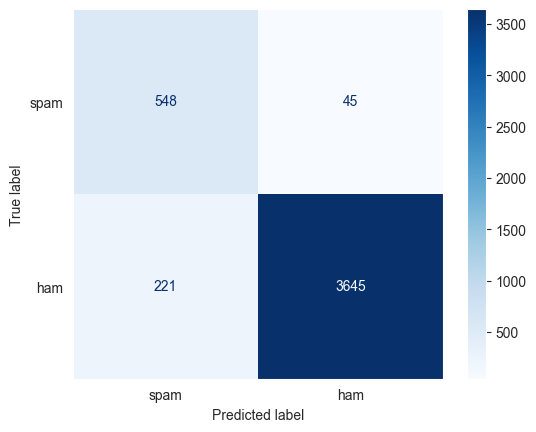

In [90]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_train.labels)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()

**5. $\star$ During training we will calculate a number of metrics, create a function to plot these:**
- Look up Sensitivity and Specificity if you are in doubt about what they measure

In [83]:
def plot_metrics(metrics):
    metrics = np.array(metrics)
    metric_names = ['Loss', 'Accuracy', 'Sensitivity', 'Specificity']
    colors = ['red', 'blue', 'green', 'orange']
    
    # Create plots
    plt.figure(figsize=(12, 8))
    
    for i in range(len(metric_names)):
        plt.subplot(2, 2, i + 1)
        plt.plot(range(1, len(metrics[:, i])+1), metrics[:, i], marker='o', label=metric_names[i], color=colors[i])
        plt.title(f'{metric_names[i]} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric_names[i])
        plt.xticks(range(1, len(metrics[:, i]) +1))
        if i == 0:
            plt.ylim(bottom=0)  # Only for Loss, no upper limit
        else:
            plt.ylim(0, 1)  # Set y-limits for accuracy, sensitivity, specificity
        plt.grid()
        plt.legend()
    
    plt.tight_layout()  # Adjust the layout
    plt.show()

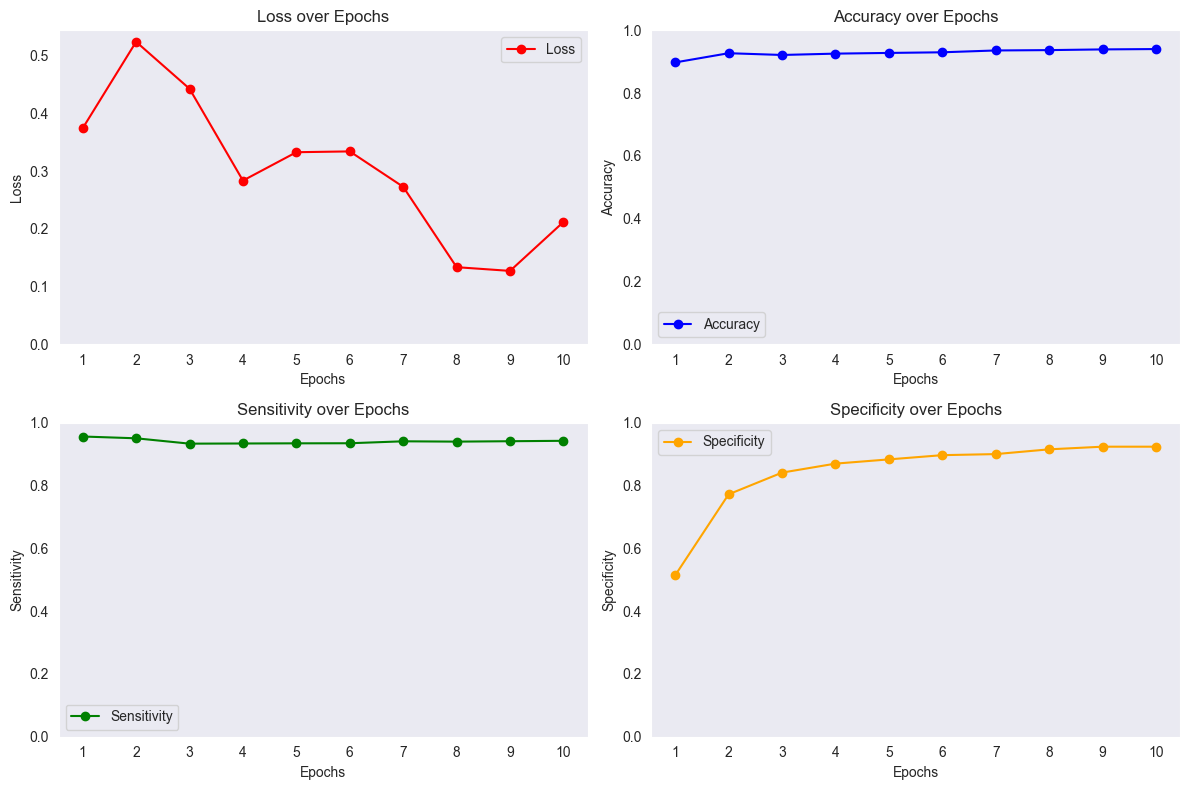

In [92]:
plot_metrics(metrics)

**6. During training we saved the network after each epoch, load the network you want to test:**

In [85]:
epoch_load = 9
model.load_state_dict(torch.load(os.path.join(model_save_dir, f"{epoch_load}.pth"), weights_only=True))

<All keys matched successfully>

**7. Test the network using the loop below:**
- How well does it perform, would you use this for spam detection in a real application?
- Can you improve it?
- The comparison between a word and character model is especially interesting if you consider what the data consists of, why?
The data contains a LOT of spelling mistakes and a word gram model will see two words that are the same but mispelled as two unique words, whereas the character model will have many tokens that end up the same.

Using char gram model
__label__ham :)  =  was skipped
Test loss: 7.9195, Test accuracy: 0.9398 Sensitivity: 0.9221, Specificity: 0.9426


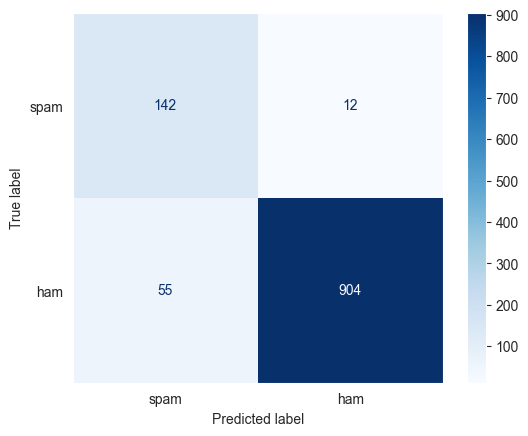

In [133]:
dataset_test = TextDataset('data/test_data.txt', vocab=dataset_train.vocab, embedding=dataset_train.embedding, minn=minn, maxn=maxn)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

accuracy_test = 0
loss_test = 0
all_labels = []
all_preds = []

for texts_embedded, labels in dataloader_test:
    outputs = model(texts_embedded)
    loss_test += criterion(outputs, labels) 
    
    preds = outputs.argmax(1)
    accuracy_test += torch.sum(preds == labels)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())
    
    # Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate sensitivity and specificity
tp, fn, fp, tn = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {accuracy_test / len(all_labels):.4f} "
      f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_test.labels)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()

## Exercise 6: The Fasttext Library

The above implementation of a Fasttext model is slow and not particularly accurate (unless you made some magic happen). In this exercise we will see how much more efficient and accurate the library implementation of Fasttext is.

There are a number of parameters that can be passed to the FastText `train_supervised` function, but we will just concern ourselves with a couples of them.

*The `input` parameter requires a text file as an input containing two columns. The first column must be the classification label and the second must be the text. The format we implemented above*
*The `verbose` parameter just allows us to enable or disable training information. Here we enable it.*

**1. Train a Fasttext model, this can be done with a single line of code**

*How long did it take compared to the Pytorch implementation?*

In [99]:
fasttext_word_model = fasttext.train_supervised(input='./data/train_data.txt', verbose=True, wordNgrams=3)

**2. Implement the following test function that computes the same metrics as we did for our ownd function.**
1. Loop across the test_texts and labels and use the model to predict the label
    - `model.predict(text)[0][0]` returns a string with the signature `__label__{label}`
2. Keep track of the predictions and labels in two separate lists
3. Use the same function to calculate and display the confusion matrix
4. Calculate the specificity and sensitivity using the same formulas as we did for the other model

In [134]:
def test_fasttext_model(test_texts, test_labels, fasttext_model, verbose=False):
    predictions = []
    true_labels = []
    
    for text, label in zip(test_texts, test_labels):
        prediction = fasttext_model.predict(text)[0][0].replace('__label__', '')
        predictions.append(prediction)
        true_labels.append(label)
    
    # Calculate confusion matrix
    labels = sorted(set(test_labels))[::-1]  # Ensure consistent label order
    cm = confusion_matrix(true_labels, predictions, labels=labels)


    # Calculate sensitivity and specificity
    tp, fn, fp, tn = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    accuracy = (tp + tn) / np.sum(cm)

    # Print metrics if verbose
    if verbose:
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap="Blues")
        plt.grid(False)
        plt.show()
    
        print(f"Sensitivity: {sensitivity:.2f}")
        print(f"Specificity: {specificity:.2f}")
        print(f'Model accuracy: {accuracy * 100:.2f} %')
    
    return accuracy, cm, sensitivity, specificity

*Now test the model. We re-train here so it is easier to change the parameters and see the results*

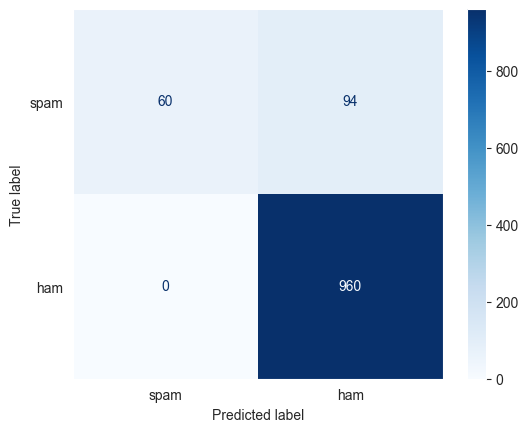

Sensitivity: 0.39
Specificity: 1.00
Model accuracy: 91.56 %


In [135]:
fasttext_word_model = fasttext.train_supervised(input='./data/train_data.txt', verbose=True, wordNgrams=5)
accuracy_word_model, cm_word_model, sens_word_model, spec_word_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_word_model, verbose=True)

**3. What happens when you vary the N-gram size (when testing)? What is the optimal setting? Why do you think that is the case?**
    
ANASWER: The lower the N the better. The dataset contains short sentences and few repeats of the same phrases.

In [136]:
metrics = []
for N in range(1, 8):
    fasttext_word_model = fasttext.train_supervised(input='./data/train_data.txt', verbose=True, wordNgrams=N)
    accuracy_word_model, cm_word_model, sens_word_model, spec_word_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_word_model, verbose=False)
    metrics.append((N, accuracy_word_model, sens_word_model, spec_word_model))

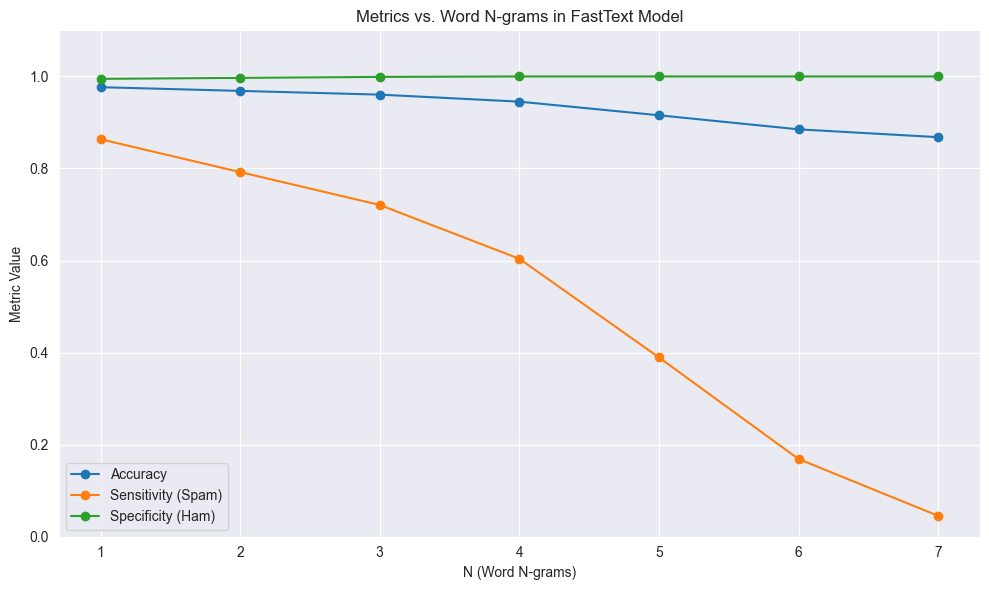

In [138]:
n_values, accuracies, sensitivities, specificities = zip(*metrics)
# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(n_values, accuracies, marker='o', label="Accuracy")
plt.plot(n_values, sensitivities, marker='o', label="Sensitivity (Spam)")
plt.plot(n_values, specificities, marker='o', label="Specificity (Ham)")

# Labeling
plt.title("Metrics vs. Word N-grams in FastText Model")
plt.xlabel("N (Word N-grams)")
plt.ylabel("Metric Value")
plt.ylim(0, 1.1)  # Since metrics are between 0 and 1
plt.xticks(n_values)  # Show only integer N values on the x-axis
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()

plt.show()

**4. Look in the FastText documentation to find out how to make a character level model. Can you get better performance this way? Why do you think that is/isn't?**

*HINT: Look at the `maxn` and `minn` parameters.*
- Can you find optimal values for the min and max?

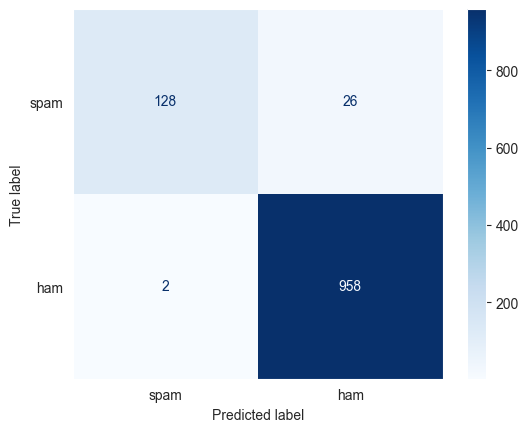

Sensitivity: 0.83
Specificity: 1.00
Model accuracy: 97.49 %


In [141]:
#Create char model here.
char_gram_length_min = 1 # If set to zero, we only train word-grams
char_gram_length_max = 3 # If set to zero, we only train word-grams

fasttext_char_model = fasttext.train_supervised(
    input='./data/train_data.txt',
    verbose=True,
    minn=char_gram_length_min,
    maxn=char_gram_length_max
)
accuracy_char_model, cm_char_model, sens_char_model, spec_char_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_char_model, verbose=True)

In [142]:
start = 1
stop = 8
results = []

for i in tqdm(range(start, stop)):
    temp_results = []
    for j in tqdm(range(start, stop)):

        fasttext_char_model = fasttext.train_supervised(
            input='./data/train_data.txt',
            verbose=True,
            minn=i,
            maxn=j,
        )
        accuracy_char_model, cm_char_model, sens_char_model, spec_char_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_char_model, verbose=False)
        temp_results.append(accuracy_char_model)
    results.append(temp_results)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

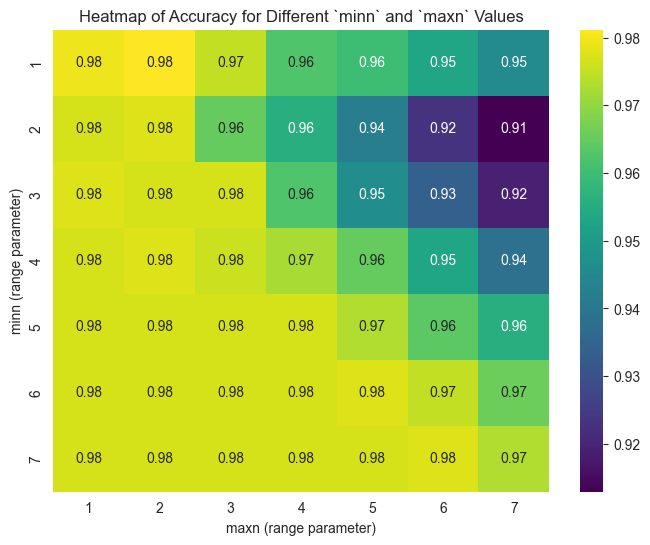

In [143]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, cmap="viridis", xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.xlabel("maxn (range parameter)")
plt.ylabel("minn (range parameter)")
plt.title("Heatmap of Accuracy for Different `minn` and `maxn` Values")
plt.show()

**5. With this new information about what minn and maxn to use, try running our homemade model with these parameters!**